##### 新潟大学大学院医歯学総合研究科　顎顔面放射線学分野　学生演習用
Modified by H.Nishiyama<br>
Fork from :https://github.com/oreilly-japan/deep-learning-from-scratch-5<br>
<br>
階層型VAE（2階層）<br>
ローカル環境実行テスト確認版<br>
テキスト：付録C，p.288-290にコードあり<br>


In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import datasets, transforms

In [2]:
# hyperparameters
input_dim = 784  # mnist image 28x28
hidden_dim = 100
latent_dim = 20
epochs = 30
learning_rate = 1e-3
batch_size = 32

In [3]:
class Encoder(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.linear = nn.Linear(input_dim, hidden_dim)
        self.linear_mu = nn.Linear(hidden_dim, latent_dim)
        self.linear_logvar = nn.Linear(hidden_dim, latent_dim)

    def forward(self, x):
        h = self.linear(x)
        h = F.relu(h)
        mu = self.linear_mu(h)
        logvar = self.linear_logvar(h)
        sigma = torch.exp(0.5 * logvar)
        return mu, sigma

In [4]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim, use_sigmoid=False):
        super().__init__()
        self.linear1 = nn.Linear(latent_dim, hidden_dim)
        self.linear2 = nn.Linear(hidden_dim, output_dim)
        self.use_sigmoid = use_sigmoid

    def forward(self, z):
        h = self.linear1(z)
        h = F.relu(h)
        h = self.linear2(h)
        if self.use_sigmoid:
            h = F.sigmoid(h)
        return h

In [5]:
def reparameterize(mu, sigma):
    eps = torch.randn_like(sigma)
    z = mu + eps * sigma
    return z

In [6]:
class VAE(nn.Module):
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super().__init__()
        self.encoder1 = Encoder(input_dim, hidden_dim, latent_dim)
        self.encoder2 = Encoder(latent_dim, hidden_dim, latent_dim)
        self.decoder1 = Decoder(latent_dim, hidden_dim, input_dim, use_sigmoid=True)
        self.decoder2 = Decoder(latent_dim, hidden_dim, latent_dim)

    def get_loss(self, x):
        mu1, sigma1 = self.encoder1(x)
        z1 = reparameterize(mu1, sigma1)
        mu2, sigma2 = self.encoder2(z1)
        z2 = reparameterize(mu2, sigma2)

        z_hat = self.decoder2(z2)
        x_hat = self.decoder1(z1)

        # loss
        batch_size = len(x)
        L1 = F.mse_loss(x_hat, x, reduction='sum')
        L2 = - torch.sum(1 + torch.log(sigma2 ** 2) - mu2 ** 2 - sigma2 ** 2)
        L3 = - torch.sum(1 + torch.log(sigma1 ** 2) - (mu1 - z_hat) ** 2 - sigma1 ** 2)
        return (L1 + L2 + L3) / batch_size

#### 「data」フォルダを1つ上のフォルダに変更
step06,step07と同じデータセットを利用するために「./data」を「../data」へ修正

In [8]:
# dataset
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Lambda(torch.flatten)
            ])
#=# dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
dataset = datasets.MNIST(root='../data', train=True, download=True, transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [9]:
model = VAE(input_dim, hidden_dim, latent_dim)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [10]:
for epoch in range(epochs):
    loss_sum = 0.0
    cnt = 0

    for x, label in dataloader:
        optimizer.zero_grad()
        loss = model.get_loss(x)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        cnt += 1

    loss_avg = loss_sum / cnt
    print(loss_avg)

49.69246834309896
43.138590513102216
41.43246163330078
40.756742797851565
40.31805537109375
40.11247172241211
39.9108394917806
39.76365481363932
39.65668261311849
39.57251205647786
39.44133468933106
39.36697058308919
39.27775571492513
39.23417795410156
39.19574333496094
39.14816289469401
39.1329952351888
39.05600157267253
39.03803572794596
39.02214404602051
38.98472150675456
38.94474438680013
38.929565199788414
38.91169647216797
38.860426574707034
38.849144911702474
38.826366251627604
38.82722880859375
38.79180428873698
38.781708203125


In [11]:
 # visualize generated images
with torch.no_grad():
    sample_size = 64
    z2 = torch.randn(sample_size, latent_dim)
    z1_hat = model.decoder2(z2)
    z1 = reparameterize(z1_hat, torch.ones_like(z1_hat))
    x = model.decoder1(z1)
    generated_images = x.view(sample_size, 1, 28, 28)

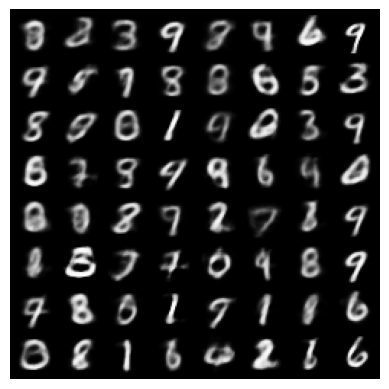

In [13]:
grid_img = torchvision.utils.make_grid(generated_images, nrow=8, padding=2, normalize=True)
plt.imshow(grid_img.permute(1, 2, 0))
plt.axis('off')
plt.show()